# Discovering the influential factors in variational autoencoders

In [1]:
%matplotlib inline 
# %pylab osx
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [2]:
# Load data
(train_and_validation_images, train_and_validation_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = np.reshape(train_and_validation_images[10000:],(-1,28, 28, 1)).astype('float32')
validation_images = np.reshape(train_and_validation_images[:10000],(-1,28, 28, 1)).astype('float32')
test_images = np.reshape(test_images[:10000],(-1,28, 28, 1)).astype('float32')

train_labels = train_and_validation_labels[10000:]
validation_labels = train_and_validation_labels[:10000]
train_images /= 255.
validation_images /= 255.
test_images /= 255.

In [3]:
TRAIN_BUF = 50000
BATCH_SIZE = 100
VALIDATION_BUF = 10000
TEST_BUF = 10000

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels)).shuffle(TEST_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(TEST_BUF).batch(BATCH_SIZE)

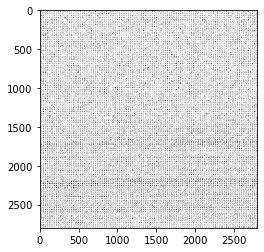

In [5]:
def montage(images, saveto='montage.png'):
    """Draw all images as a montage separated by 0 pixel borders.

    Also saves the file to the destination specified by `saveto`.

    Parameters
    ----------
    images : numpy.ndarray
        Input array to create montage of.  Array should be:
        batch x height x width x channels.
    saveto : str
        Location to save the resulting montage image.

    Returns
    -------
    m : numpy.ndarray
        Montage image.
    """
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    if len(images.shape) == 4 and images.shape[3] == 3:
        m = np.ones(
            (images.shape[1] * n_plots ,
             images.shape[2] * n_plots , 3)) * 0.5
    else:
        m = np.ones(
            (images.shape[1] * n_plots  ,
             images.shape[2] * n_plots )) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[i * img_h: (i + 1) * img_h,
                 j * img_w: (j + 1) * img_w] = this_img
    plt.imsave(arr=m, fname=saveto,cmap="gray")
    return m
plt.imshow(montage(1-test_images.reshape((-1, 28, 28)),saveto="sprite_for_mnist.png"),cmap='gray')

(28, 28, 1)


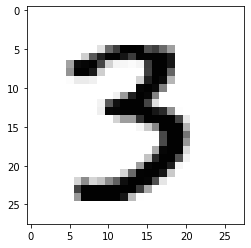

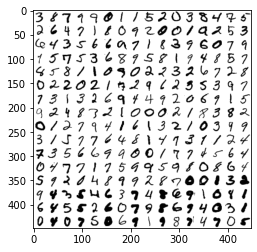

In [6]:
# Visualize data
print(train_images[0].shape)
plt.imshow(1-train_images[0].reshape((28, 28)), cmap='gray')

# Let's get the first 256 images of the dataset and reshape them
imgs = train_images[:256].reshape((-1, 28, 28))

# Then create a montage and draw the montage
plt.figure()
plt.imshow(montage(1-imgs), cmap='gray')

#### Network Setting

In [7]:
#filter_sizes=[4,4]
#strides_sizes=[2,2]
#n_filters=[32,32]

In [8]:
class BetaVAE(tf.keras.Model):
    def __init__(self, latent_dim, hidden_dim, beta = 6):
        super(BetaVAE, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.beta = beta
        self.sigma = tf.Variable(1.0)
        self.inference_net = tf.keras.Sequential(
          [
              tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
              tf.keras.layers.Conv2D(
                  filters=32, kernel_size=4, strides=(2, 2), activation='relu',padding="SAME"),
              tf.keras.layers.Conv2D(
                  filters=32, kernel_size=4, strides=(2, 2), activation='relu',padding="SAME"),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(self.hidden_dim,activation=tf.nn.relu),
              tf.keras.layers.Dense(latent_dim + latent_dim),
          ]
        )

        self.generative_net = tf.keras.Sequential(
            [
              tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
              tf.keras.layers.Dense(units=self.hidden_dim, activation=tf.nn.relu),  
              tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
              tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
              tf.keras.layers.Conv2DTranspose(
                  filters=32,
                  kernel_size=4,
                  strides=(2, 2),
                  padding="SAME",
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose(
                  filters=1,
                  kernel_size=4,
                  strides=(2, 2),
                  padding="SAME",
                  activation='relu'),
            ]
        )


    def sample(self, batchsize=100):
        eps = tf.random.normal(shape=(batchsize, self.latent_dim))
        return self.decode(eps)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        return self.generative_net(z)
    
    def call(self,x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return self.generative_net(mean)

## Define loss and optimizier

VAEs maximize ELBO：

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right]=\mathbb{E}_{q(z|x)}p(x| z)-D_{KL}(q(z|x)||p(z))$$
$\beta-VAEs$ introduce $\beta$ to the KL-divergence term, 
$$\text{ELBO}\ge\mathbb{E}_{q(z|x)}p(x| z)-\beta D_{KL}(q(z|x)||p(z))$$
$\forall \beta\ge1$.

In [9]:
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_reconstruct = model.decode(z)

  Eqz_x_logpx_z = -tf.reduce_sum(tf.math.pow((x-x_reconstruct),2.0)/(2.0*tf.math.pow(model.sigma,2))
                                 +tf.math.log(model.sigma)+0.5*tf.math.log(2*np.pi), axis=[1, 2, 3])
  Dklqz_x_pz = tf.reduce_sum(-0.5 *( 1.0 + logvar -tf.square(mean) - tf.exp( logvar)),axis=1)
  
  return -tf.reduce_mean(Eqz_x_logpx_z - model.beta * Dklqz_x_pz)

def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [10]:
epochs = 100
# dim of z
latent_dim =128
# dim of fc hidden layer
hidden_dim = 256
num_examples_to_generate = 16

model = BetaVAE(latent_dim,hidden_dim)

optimizer = tf.keras.optimizers.Adam(1e-3)

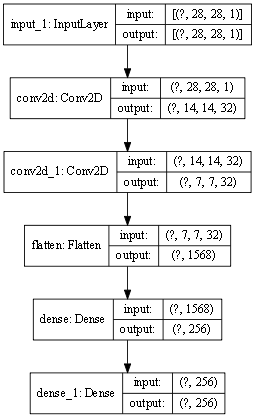

In [11]:
tf.keras.utils.plot_model(model.inference_net, show_shapes=True, dpi=64)

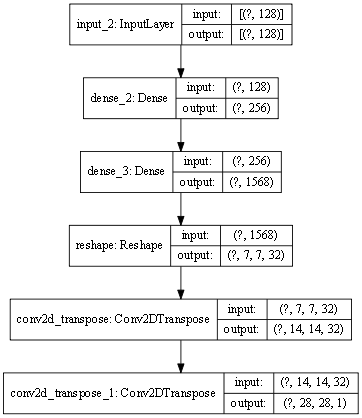

In [12]:
tf.keras.utils.plot_model(model.generative_net, show_shapes=True, dpi=64)

In [13]:
####Dirs
Model_name="VAE_MNIST_latents_{0}_beta_{1}_epochs_{2}/".format(latent_dim,model.beta,epochs)
dir_name_for_documents ='./VAE_MNIST_Documents/'+Model_name
dir_name_for_figures = './VAE_MNIST_Documents/'+Model_name+"figures/"

if not os.path.exists(os.path.dirname(dir_name_for_documents )):
    os.makedirs(os.path.dirname(dir_name_for_documents ))

if not os.path.exists(os.path.dirname(dir_name_for_figures)):
    os.makedirs(os.path.dirname(dir_name_for_figures))

In [14]:
model.trainable=True
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x,_ in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for validation_x,_ in validation_dataset:
      loss(compute_loss(model, validation_x))
    elbo = -loss.result()
    print('Epoch: {}, Test set -loss: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    reconstruct_validation_images = model(validation_images[:100])
    reconstruction = np.clip(tf.reshape(reconstruct_validation_images,(-1, 28,28)), 0,1)
    img = montage(1-reconstruction,saveto=dir_name_for_figures +'MNIST_epoch{0}.png'.format(epoch))



Epoch: 1, Test set -loss: -214.43479919433594, time elapse for current epoch 18.642720937728882
Epoch: 2, Test set -loss: 84.75586700439453, time elapse for current epoch 18.239223957061768
Epoch: 3, Test set -loss: 190.0337677001953, time elapse for current epoch 17.257871866226196
Epoch: 4, Test set -loss: 264.46124267578125, time elapse for current epoch 17.486244440078735
Epoch: 5, Test set -loss: 308.1750793457031, time elapse for current epoch 17.20304250717163
Epoch: 6, Test set -loss: 335.1600036621094, time elapse for current epoch 17.0198655128479
Epoch: 7, Test set -loss: 361.1782531738281, time elapse for current epoch 16.758172512054443
Epoch: 8, Test set -loss: 381.5849914550781, time elapse for current epoch 17.530120611190796
Epoch: 9, Test set -loss: 399.4023132324219, time elapse for current epoch 17.034411907196045
Epoch: 10, Test set -loss: 414.23089599609375, time elapse for current epoch 16.674469232559204
Epoch: 11, Test set -loss: 423.2603759765625, time elapse 

Epoch: 88, Test set -loss: 532.6503295898438, time elapse for current epoch 26.19594717025757
Epoch: 89, Test set -loss: 529.091552734375, time elapse for current epoch 23.750484943389893
Epoch: 90, Test set -loss: 527.2853393554688, time elapse for current epoch 25.189162015914917
Epoch: 91, Test set -loss: 531.9097900390625, time elapse for current epoch 21.630162715911865
Epoch: 92, Test set -loss: 529.472900390625, time elapse for current epoch 19.555703163146973
Epoch: 93, Test set -loss: 528.0025634765625, time elapse for current epoch 20.208930492401123
Epoch: 94, Test set -loss: 531.2118530273438, time elapse for current epoch 25.92666459083557
Epoch: 95, Test set -loss: 532.178466796875, time elapse for current epoch 23.021416425704956
Epoch: 96, Test set -loss: 533.8860473632812, time elapse for current epoch 21.90841293334961
Epoch: 97, Test set -loss: 531.7130737304688, time elapse for current epoch 26.562963008880615
Epoch: 98, Test set -loss: 534.2899780273438, time elaps

We want to obtain the q(z) for the encoder network.

Let $q^*(z)=N(z|0,diag(\sigma_1^{*2}(x),\cdots,\sigma_H^{*2}(x)))$. By solving the following,
$$q^*(z)=\arg \min_{q}\frac{1}{M}\sum_{m=1}^M D_{KL}(q(z|x)||q(z))$$, it yields
$$\sigma_i^{*2}=\frac{1}{M}\sum_{m=1}^M \sigma_i^2(x^m)+\mu_i^2(x^m)$$
where $q(z|x)=N(z|\mu(x),diag(\sigma_1^2(x),\cdots,\sigma_H^2(x)))$.

In [15]:
mean, logvar = model.encode(validation_images)
sigma_star2 = tf.reduce_mean(tf.exp(logvar)+tf.square(mean),axis=0)

#### $\sigma$ doesn't encode the usage of z

D:\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

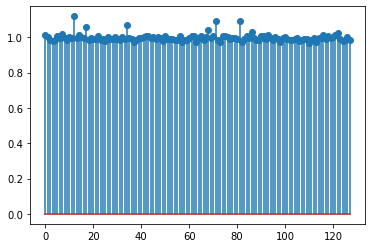

In [16]:
plt.stem(tf.sqrt(sigma_star2))

### Calculate the mutual information

In [17]:
Ih = tf.reduce_mean(0.5 * (tf.math.log(sigma_star2)- logvar +
                           (tf.exp(logvar)+tf.square(mean))/sigma_star2-1),axis=0)

### The mutual information sparsity occurs.

D:\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

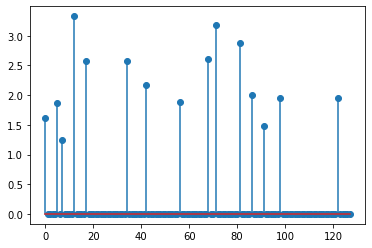

In [18]:
plt.stem(Ih)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



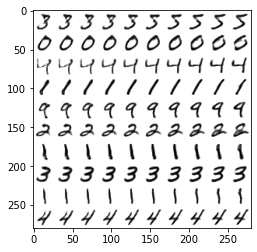

In [19]:
def plot_latents(num=4,threshold=0.9):
    sample_z,_ = model.encode(validation_images[:num])
    for k in range(latent_dim):    
        if Ih[k]<threshold:
            continue

        sample_z_set=np.zeros([num*num,latent_dim])
        for i in range(num):
            for m in range(num):
                sample_z_set[i*num+m]=sample_z[i]

        for j in range(num*num):
             sample_z_set[j,k] = (j%num)*(6/num)-3

        recover = model.decode(sample_z_set)
        plt.imshow(montage(np.clip(tf.reshape(1-recover,(-1, 28,28)),0,1),saveto=dir_name_for_figures+"/latent{0}.png".format(k)),cmap='gray')

plot_latents(num=10,threshold=0.5)


### Generation plot with different ratio of factors

In [20]:
index=np.array(Ih).argsort()

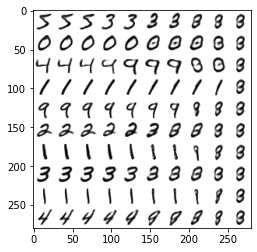

In [21]:
sample_z,_ = model.encode(validation_images[:10])
sample_z = sample_z.numpy()
# 128/128
rec_0= model.decode(sample_z)
# 24/128
sample_z[:,index[0:104]]=0
rec_1= model.decode(sample_z)
# 12/128
sample_z[:,index[0:116]]=0
rec_2= model.decode(sample_z)
# 8/128
sample_z[:,index[0:120]]=0
rec_3= model.decode(sample_z)
# 6/128
sample_z[:,index[0:122]]=0
rec_4= model.decode(sample_z)
# 4/128
sample_z[:,index[0:124]]=0
rec_5= model.decode(sample_z)
# 3/128
sample_z[:,index[0:125]]=0
rec_6= model.decode(sample_z)
# 2/128
sample_z[:,index[0:126]]=0
rec_7= model.decode(sample_z)
# 1/128
sample_z[:,index[0:127]]=0
rec_8= model.decode(sample_z)
# 0/128
sample_z[:,index[0:128]]=0
rec_9= model.decode(sample_z)
rec=tf.concat([rec_0,rec_1,rec_2,rec_3,rec_4,rec_5,rec_6,rec_7,rec_8,rec_9], axis=1)
plt.imshow(montage(np.clip(tf.reshape(1-rec,(-1, 28,28)),0,1),saveto=dir_name_for_figures+"/different_information_ratio_reconstruction.png"),cmap='gray')


In [22]:
class CLS(tf.keras.Model):
    def __init__(self, latent_dim, hidden_dim):
        super(CLS, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim

        self.classification_net = tf.keras.Sequential(
            [
              tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
              tf.keras.layers.Dense(units=self.hidden_dim, activation=tf.nn.relu),  
              tf.keras.layers.Dense(10, activation='softmax'),
            ]
        )
    
    def call(self,z):
        return self.classification_net(z)

In [23]:
model_classification =CLS(latent_dim, hidden_dim)

In [24]:
loss_object_cls = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer_cls = tf.keras.optimizers.Adam(1e-3)

In [25]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

validation_loss = tf.keras.metrics.Mean(name='validation_loss')
validation_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='validation_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [26]:
model.trainable=False
model_classification.trainable=True

In [27]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        mean, _ = model.encode(images)
        predictions = model_classification(mean)
        loss = loss_object_cls(labels, predictions)
    gradients = tape.gradient(loss, model_classification.trainable_variables)
    optimizer_cls.apply_gradients(zip(gradients, model_classification.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

In [28]:
def validation_step(images, labels):
    mean, _ = model.encode(images)
    predictions = model_classification(mean)
    v_loss = loss_object_cls(labels, predictions)

    validation_loss(v_loss)
    validation_accuracy(labels, predictions)

In [30]:
EPOCHS = 20

for epoch in range(EPOCHS):
  # 在下一个epoch开始时，重置评估指标
    train_loss.reset_states()
    train_accuracy.reset_states()
    validation_loss.reset_states()
    validation_accuracy.reset_states()


    for images, labels in train_dataset:
        train_step(images, labels)

    for validation_images, validation_labels in validation_dataset:
        validation_step(validation_images, validation_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Validation Loss: {}, Validation Accuracy: {}'
    print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         validation_loss.result(),
                         validation_accuracy.result()*100))


Epoch 1, Loss: 0.09759912639856339, Accuracy: 97.16400146484375, Validation Loss: 0.09424535930156708, Validation Accuracy: 97.13999938964844
Epoch 2, Loss: 0.08086947351694107, Accuracy: 97.66999816894531, Validation Loss: 0.0841035544872284, Validation Accuracy: 97.36000061035156
Epoch 3, Loss: 0.07174743711948395, Accuracy: 97.88800048828125, Validation Loss: 0.07622562348842621, Validation Accuracy: 97.55999755859375
Epoch 4, Loss: 0.06561499834060669, Accuracy: 98.03599548339844, Validation Loss: 0.0726732462644577, Validation Accuracy: 97.81999969482422
Epoch 5, Loss: 0.06028293818235397, Accuracy: 98.23999786376953, Validation Loss: 0.07027190923690796, Validation Accuracy: 97.83999633789062
Epoch 6, Loss: 0.05605374649167061, Accuracy: 98.31200408935547, Validation Loss: 0.06941059976816177, Validation Accuracy: 97.87999725341797
Epoch 7, Loss: 0.05309620872139931, Accuracy: 98.41200256347656, Validation Loss: 0.06494230777025223, Validation Accuracy: 98.02999877929688
Epoch 8,

In [31]:
def test_step(images, labels, ratio =1):
    mean, _ = model.encode(images)
    mean = mean.numpy()
    if ratio == 1:
        predictions = model_classification(mean)
    else:
        mean[:,index[0:np.int((1-ratio)*128)]]=0
        predictions = model_classification(mean)
    t_loss = loss_object_cls(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [32]:
for ratio in [1,0.5,0.1,0.07,0.05,0.04,0.03,0.02,0.01,0]:
    test_loss.reset_states()
    test_accuracy.reset_states()
    for images, labels in test_dataset:
        test_step(images, labels,ratio=ratio)
    print("percentage {0}, accuracy {1}".format(ratio*100,test_accuracy.result().numpy()*100))

percentage 100, accuracy 98.05999994277954
percentage 50.0, accuracy 97.82999753952026
percentage 10.0, accuracy 93.12999844551086
percentage 7.000000000000001, accuracy 85.53000092506409
percentage 5.0, accuracy 78.40999960899353
percentage 4.0, accuracy 75.01999735832214
percentage 3.0, accuracy 51.92999839782715
percentage 2.0, accuracy 35.71000099182129
percentage 1.0, accuracy 26.46999955177307
percentage 0, accuracy 10.090000182390213
